In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage

In [3]:
def mascara(imagen):
    puntos_referencia = np.array([(1, 374), (1231, 374),(705, 176) ,(501, 176) ], dtype=np.int32)
    mascara = np.zeros_like(imagen)
    cv2.fillPoly(mascara, [puntos_referencia], (255, 255, 255)) 
    imagen_resultado = cv2.bitwise_and(imagen, mascara)
    return imagen_resultado

In [4]:
def draw_lines(img, lines, color=[255, 0, 0], thickness=7):
    for line in lines:
        for x1, y1, x2, y2 in line:
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)

In [5]:
def rgb2gray(rgb):
    return np.dot(rgb[..., :3], [0.299, 0.587, 0.114]).astype(np.uint8)

In [6]:
def kernel_gaussiano (img):
    mascara = np.array([[1, 4,  7,  4,  1], 
                        [4, 16, 26, 16, 4], 
                        [7, 26, 41, 26, 7],
                        [4, 16, 26, 16, 4],
                        [1, 4,  7,  4,  1]])

    mascara = mascara /273  #normalización de la mascar
    mascaraf, mascaraC = mascara.shape

    filas,columnas,canales = img.shape# obtención de los tamaños de las imagenes 
    bordeH = int((mascaraf-1)/2)
    bordeA = int((mascaraC-1)/2)

    matrizF = np.zeros((filas + (mascaraf-1), columnas + (mascaraC-1),canales))#matriz mas grande para eviatar el desbordamiento

    matrizF[bordeH:filas+bordeH, bordeA:columnas+bordeA] = img # se copia la imagen 

    matrizfinal = np.zeros_like(img)# se genera la matriz en donde se almacenan los datos 

    for i in range(bordeH, filas + bordeH):
        for j in range(bordeA, columnas + bordeA):
            matrizfinal[i-bordeH, j-bordeA, 0] = np.sum(mascara * matrizF[i-bordeH:i+bordeH+1, j-bordeA:j+bordeA+1, 0])
            matrizfinal[i-bordeH, j-bordeA, 1] = np.sum(mascara * matrizF[i-bordeH:i+bordeH+1, j-bordeA:j+bordeA+1, 1])
            matrizfinal[i-bordeH, j-bordeA, 2] = np.sum(mascara * matrizF[i-bordeH:i+bordeH+1, j-bordeA:j+bordeA+1, 2])

    return matrizfinal

In [7]:
def Gradientes (imgarr):
    filas,columnas,ca = imgarr.shape
    #La imagen se convierte a escala de grises 
    img = np.dot(imgarr[...,:3], [0.299, 0.587, 0.114])

    h,w=img.shape

    mascara_x = np.array([[-1, 0, 1], 
                        [-2, 0, 2], 
                        [-1, 0, 1]])

    mascara_y = np.array([[-1, -2, -1], 
                        [ 0,  0,  0], 
                        [ 1,  2,  1]])

    mascaraf, mascaraC = mascara_x.shape
    bordeH = int((mascaraf-1)/2)
    bordeA = int((mascaraC-1)/2)
    matrizF = np.zeros((filas + (mascaraf-1), columnas + (mascaraC-1)))#matriz mas grande para eviatar el desbordamiento

    matrizF[bordeH:filas+bordeH, bordeA:columnas+bordeA] = img # se copia la imagen 

    matrizfinal_x = np.zeros_like(img)# se genera la matriz en donde se almacenan los datos 
    matrizfinal_y = np.zeros_like(img)
    gradiente = np.zeros_like(img)
    gradiente_angulo = np.zeros_like(img)

    for i in range(bordeH, filas + bordeH):
        for j in range(bordeA, columnas + bordeA):
            matrizfinal_x[i-bordeH, j-bordeA] = np.sum(mascara_x * matrizF[i-bordeH:i+bordeH+1, j-bordeA:j+bordeA+1])
            matrizfinal_y[i-bordeH, j-bordeA] = np.sum(mascara_y * matrizF[i-bordeH:i+bordeH+1, j-bordeA:j+bordeA+1])
            gradiente[i-bordeH, j-bordeA] = np.sqrt((matrizfinal_x[i-bordeH, j-bordeA]**2) + (matrizfinal_y[i-bordeH, j-bordeA]**2))
            gradiente_angulo[i-bordeH, j-bordeA] = np.arctan2(matrizfinal_y[i-bordeH, j-bordeA], matrizfinal_x[i-bordeH, j-bordeA])
            
    return gradiente, gradiente_angulo

In [8]:
def supresionM(gradiente_magnitud, gradiente_angulo):
    filas, columnas = gradiente_magnitud.shape
    maximosl = np.zeros_like(gradiente_magnitud)
    #Obtenemos los grads que tiene cada pixel
    angulos = gradiente_angulo * 180 / np.pi
    #Nos aseguramos que se encuentre dentro del rango de 0 a 180
    angulos[angulos < 0] += 180

    for i in range(1, filas - 1):
        for j in range(1, columnas - 1):
            #Verificación de los ángulos de capa pixel
            if ( 0 <= angulos[i,j] < 22.5) or ( 157.5 <= angulos[i,j]< 180):
                cercanos =  (gradiente_magnitud[i,j-1], gradiente_magnitud[i, j], gradiente_magnitud[i, j + 1])
            elif (22.5 <= angulos[i,j] < 67.5):
                cercanos = (gradiente_magnitud[i - 1, j - 1], gradiente_magnitud[i, j], gradiente_magnitud[i + 1, j + 1])
            elif (67.5 <= angulos[i,j] < 112.5):
                cercanos = (gradiente_magnitud[i - 1, j], gradiente_magnitud[i, j], gradiente_magnitud[i + 1, j])
            else:
                cercanos = (gradiente_magnitud[i - 1, j + 1], gradiente_magnitud[i, j], gradiente_magnitud[i + 1, j - 1])
            if (gradiente_magnitud[i,j]>= max(cercanos)):
                maximosl[i,j] = gradiente_magnitud[i,j]

    return maximosl



In [9]:
def umbralizacion_histeresis(gradiente_suprimido, umbral_bajo, umbral_alto):
    # Aplicar la umbralización por histéresis
    bordes_fuertes = gradiente_suprimido > umbral_alto
    bordes_debiles = (gradiente_suprimido >= umbral_bajo) & (gradiente_suprimido <= umbral_alto)

    etiquetas, num_caracteristicas = ndimage.label(bordes_fuertes)

    for i in range(1, num_caracteristicas + 1):
        etiqueta_actual = (etiquetas == i)
        bordes_debiles = bordes_debiles | etiqueta_actual

    return bordes_fuertes, bordes_debiles

In [ ]:
from scipy.ndimage import maximum_filter

def houghLine(image, threshold=150, neighborhood_size=80):
    plt.figure(figsize=(20, 10))
    
    mask = image

    mascaraa = mascara(mask)

   
    blur = kernel_gaussiano(mascaraa)

    
    gradiente, gradienteAng = Gradientes(blur)
    gradienteS = supresionM(gradiente, gradienteAng)

    umbral_bajo = 50
    umbral_alto = 150
    bordes_fuertes, bordes_debiles = umbralizacion_histeresis(gradienteS, umbral_bajo, umbral_alto)

    edges = np.where(bordes_debiles > 0, 1, 0)
    
    theta_resolution=1
    rho_resolution=1
    Ny = image.shape[0]
    Nx = image.shape[1]

    Maxdist = int(np.round(np.sqrt(Nx**2 + Ny**2)))
    thetas = np.deg2rad(np.arange(-68, 80, theta_resolution)) 
    rs = np.linspace(-Maxdist, Maxdist, int(2 * Maxdist / rho_resolution))
    accumulator = np.zeros((int(2 * Maxdist / rho_resolution), len(thetas)))

    for y in range(Ny):
        for x in range(Nx):
            if edges[y, x] > 0:  
                for k in range(len(thetas)):
                    r = x * np.cos(thetas[k]) + y * np.sin(thetas[k])
                    accumulator[int(r) + int(Maxdist / rho_resolution), k] += 1

    local_maxima = maximum_filter(accumulator, size=neighborhood_size)
    accumulator[accumulator < local_maxima] = 0

    lines = np.where(accumulator > threshold)

    detected_rho = rs[lines[0]]
    detected_theta = thetas[lines[1]]

    result_image = image
    for i in range(len(detected_rho)):
        rho = detected_rho[i]
        theta = detected_theta[i]
        a = np.cos(theta)
        b = np.sin(theta)
        x0 = a * rho
        y0 = b * rho
        x1 = int(x0 + 1000 * (-b))
        y1 = int(y0 + 1000 * (a))
        x2 = int(x0 - 1000 * (-b))
        y2 = int(y0 - 1000 * (a))
        cv2.line(result_image, (x1, y1), (x2, y2), (0, 0, 255), 2)

    
    return result_image, detected_rho, detected_theta


image = cv2.imread('carretera.png')
accumulator, detected_rho, detected_theta = houghLine(image)

plt.figure(figsize=(20, 10))
plt.imshow(cv2.cvtColor(accumulator, cv2.COLOR_BGR2RGB)) 
plt.axis('off')

print('rho: ', detected_rho)
print('theta: ', detected_theta)



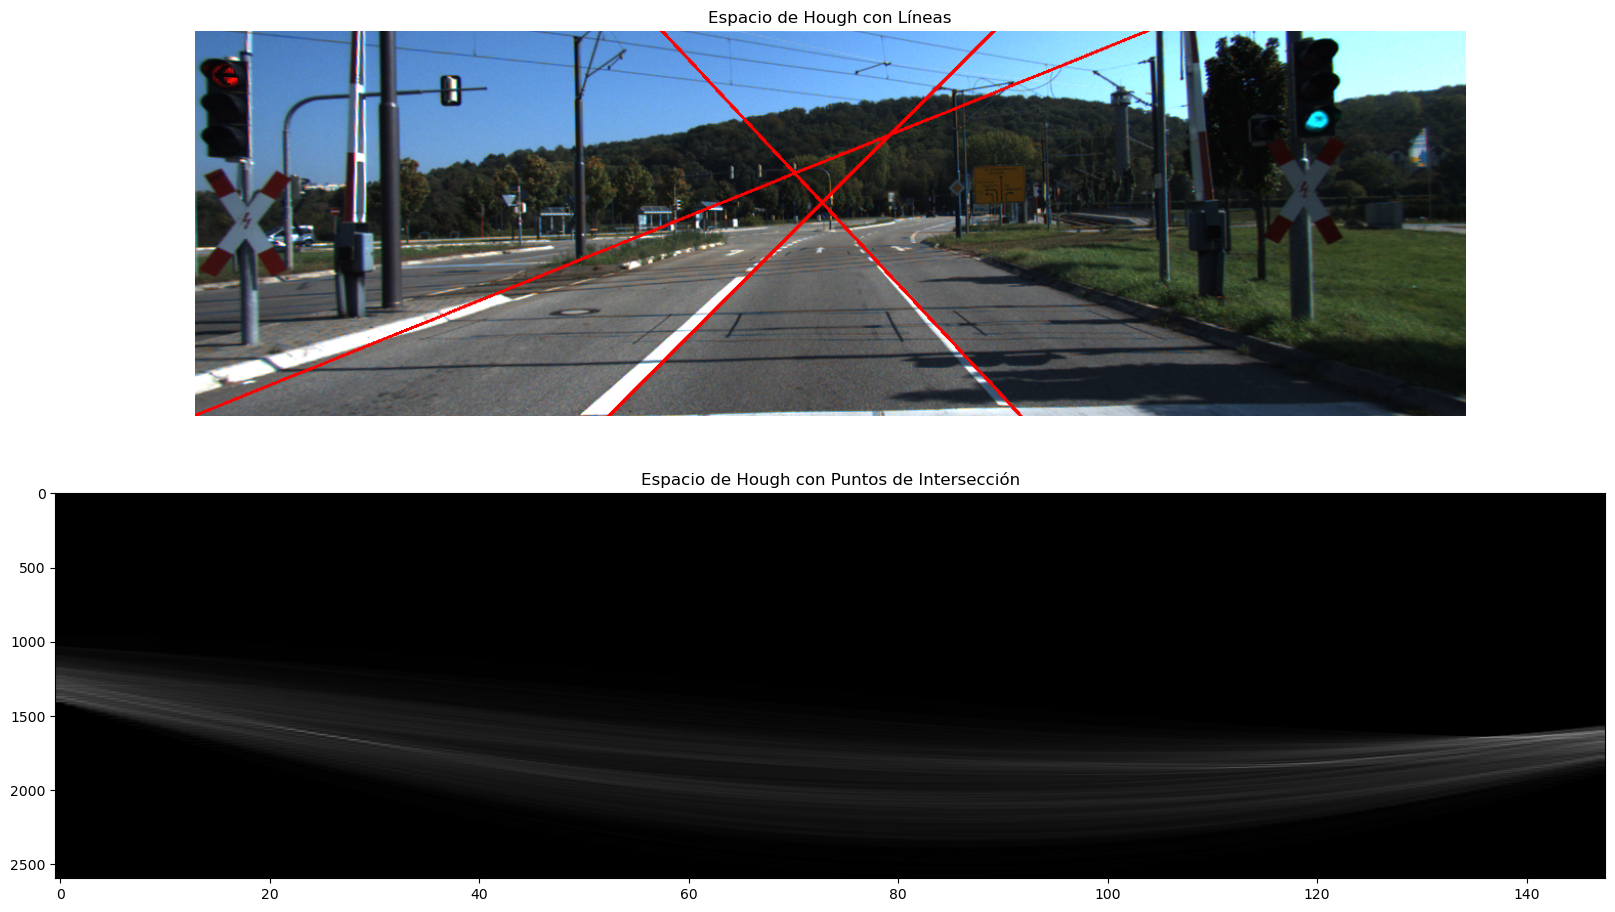

In [59]:
from scipy.ndimage import maximum_filter

def houghLine(image, threshold=150, neighborhood_size=80):
    mask = image

    mascaraa = mascara(mask)
   
    blur = kernel_gaussiano(mascaraa)
    
    gradiente, gradienteAng = Gradientes(blur)
    gradienteS = supresionM(gradiente, gradienteAng)

    umbral_bajo = 50
    umbral_alto = 150
    bordes_fuertes, bordes_debiles = umbralizacion_histeresis(gradienteS, umbral_bajo, umbral_alto)

    edges = np.where(bordes_debiles > 0, 1, 0)
    
    theta_resolution = 1
    rho_resolution = 1
    Ny = image.shape[0]
    Nx = image.shape[1]

    Maxdist = int(np.round(np.sqrt(Nx**2 + Ny**2)))
    thetas = np.deg2rad(np.arange(-68, 80, theta_resolution)) 
    rs = np.linspace(-Maxdist, Maxdist, int(2 * Maxdist / rho_resolution))
    accumulator = np.zeros((int(2 * Maxdist / rho_resolution), len(thetas)))

    for y in range(Ny):
        for x in range(Nx):
            if edges[y, x] > 0:  
                for k in range(len(thetas)):
                    r = x * np.cos(thetas[k]) + y * np.sin(thetas[k])
                    accumulator[int(r) + int(Maxdist / rho_resolution), k] += 1

    hs = np.copy(accumulator)
        
    local_maxima = maximum_filter(accumulator, size=neighborhood_size)
    
    accumulator[accumulator < local_maxima] = 0

    lines = np.where(accumulator > threshold)

    detected_lines = [(rs[line[0]], thetas[line[1]]) for line in zip(*lines)]
    
    detected_rho = rs[lines[0]]
    detected_theta = thetas[lines[1]]

    result_image = image
    for i in range(len(detected_rho)):
        rho = detected_rho[i]
        theta = detected_theta[i]
        a = np.cos(theta)
        b = np.sin(theta)
        x0 = a * rho
        y0 = b * rho
        x1 = int(x0 + 1000 * (-b))
        y1 = int(y0 + 1000 * (a))
        x2 = int(x0 - 1000 * (-b))
        y2 = int(y0 - 1000 * (a))
        cv2.line(result_image, (x1, y1), (x2, y2), (0, 0, 255), 2)
    
    return hs, result_image, detected_rho, detected_theta, detected_lines


def find_line_intersections(lines):
    intersections = []
    for i in range(len(lines)):
        for j in range(i + 1, len(lines)):
            rho1, theta1 = lines[i]
            rho2, theta2 = lines[j]
            A = np.array([
                [np.cos(theta1), np.sin(theta1)],
                [np.cos(theta2), np.sin(theta2)]
            ])
            b = np.array([rho1, rho2])
            intersection = np.linalg.solve(A, b)
            intersections.append((int(intersection[0]), int(intersection[1])))
    return intersections

image = cv2.imread('carretera8.png')

hs, result_image, detected_rho, detected_theta, detected_lines = houghLine(image)


intersections = find_line_intersections(detected_lines)

hough_space_without_lines = result_image.copy()
hough_space_without_lines[:] = [0, 0, 0]

for x, y in intersections:
    cv2.circle(hough_space_without_lines, (x, y), 5, (0, 255, 0), -1)

plt.figure(figsize=(20, 11))
plt.subplot(2,1,1)
plt.imshow(cv2.cvtColor(result_image, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.title('Espacio de Hough con Líneas')

plt.subplot(2,1,2)
plt.imshow(hs, cmap='gray')
plt.gca().set_aspect('auto') 
plt.title('Espacio de Hough con Puntos de Intersección')
plt.show()


In [65]:
print (hs)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [68]:
rhos = []
thetas = []

# Iterar sobre las líneas detectadas en el acumulador
for line in detected_lines:
    rho, theta = line[0]
    rhos.append(rho)
    thetas.append(theta)

# Crear un gráfico de dispersión (scatter plot) de los puntos de intersección
plt.scatter(thetas, rhos, marker='o', color='red', label='Puntos de intersección')
plt.title('Puntos de Intersección en el Acumulador de Hough')
plt.xlabel('Theta (θ)')
plt.ylabel('Rho (ρ)')
plt.legend()
plt.grid(True)

# Mostrar el gráfico
plt.show()

TypeError: cannot unpack non-iterable numpy.float64 object